# AVA Dataset

In [1]:
from data import AVA
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

train_dataset = AVA('data/AVA_dataset/aesthetics_image_lists/animal_train.jpgl', 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

test_dataset = AVA('data/AVA_dataset/aesthetics_image_lists/animal_test.jpgl', 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

### Toggle cell below for sample debugging

In [2]:
import torch
train_dataset = torch.utils.data.Subset(train_dataset, range(512)) 
test_dataset = torch.utils.data.Subset(test_dataset, range(512))

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=128, shuffle=True, num_workers=2)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=128, shuffle=True, num_workers=2)

In [4]:
an_item = test_dataset[0]
an_img = an_item[0]
a_label = an_item[1]

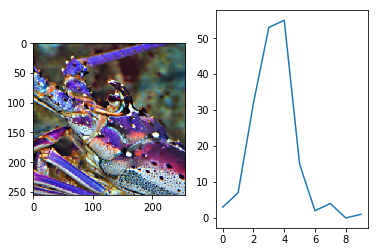

In [5]:
plt.subplot(1,2,1)
plt.imshow(an_img.numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.plot(a_label)

# Simple Model

In [6]:
from models import Classifier
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier(256, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [7]:
len(train_loader.dataset)

512

In [8]:
from tqdm import tqdm

In [9]:
def train(epoch):
    model.train()
    model.to(device)
    total_loss = 0
    for data, labels in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        labels = labels.float()
        labels = torch.nn.functional.softmax(labels, dim=1)
        preds = model(data)
        log_preds = preds.log()
        loss = F.kl_div(log_preds, labels, reduction='sum')
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss
    
def test(epoch):
    model.eval()
    model.to(device)
    total_loss = 0
    for data, labels in tqdm(test_loader):
        data = data.to(device)
        labels = labels.float()
        labels = torch.nn.functional.softmax(labels, dim=1)
        preds = model(data)
        log_preds = preds.log()
        loss = F.kl_div(log_preds, labels, reduction='sum')
        total_loss += loss.item()
        
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


CPU times: user 3.52 s, sys: 889 ms, total: 4.41 s
Wall time: 32.5 s


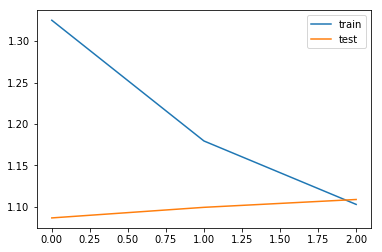

In [10]:
%%time
train_losses = []
test_losses = []
for e in range(3):
    loss = train(e)
    train_losses.append(loss)
    
    loss = test(e)
    test_losses.append(loss)

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()